In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from talib import  RSI, BBANDS, MACD, ATR
from statsmodels.tsa.stattools import adfuller


In [2]:
listOfTickers = ['AAPL', 'AMT', 'AMZN', 'BAC', 'BA',
                 'BLK', 'BRKB', 'CAT', 'COST', 'CSCO',
                 'CVX', 'DUK', 'FCX', 'GOOGL', 'HD', 
                 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN',
                 'LLY', 'MCD', 'MCTF', 'META', 'NEE',
                 'NFLX', 'NKE', 'NUE', 'NVDA', 'ORCL',
                 'PG', 'PLD', 'RTX', 'SLB', 'SO', 
                 'SPG', 'T', 'UNH', 'UNP', 'WMT', 
                 'XOM']


In [6]:
dataframes = []
for ticker in listOfTickers:
    # Read CSV
    df = pd.read_csv(f'../data/raw/{ticker}.csv')
    
    df.columns = df.columns.str.lower()
    df.rename(columns={'close/last': 'close'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
    
    # Remove dollar signs and convert to float
    columnsWithDollarSign = ['close', 'open', 'high', 'low']
    for column in columnsWithDollarSign:
        df[column] = df[column].str.replace('$', '', regex=False).astype(float)
    
    df['ticker'] = ticker

    df['returns'] = df['close'].pct_change()
    df['returns'] = df['returns'].shift(-1)
    # df['log_returns'] = np.log(df['returns'] + 1)
    
    df.dropna(inplace=True)
    
    # Store in dictionary
    dataframes.append(df)

In [7]:
df = pd.concat(dataframes, ignore_index=True)

In [8]:
df

,date,close,volume,open,high,low,ticker,returns
0,2025-10-09,254.04,38322010,257.805,258.00,253.14,AAPL,0.015824
1,2025-10-08,258.06,36496900,256.520,258.52,256.11,AAPL,-0.006123
2,2025-10-07,256.48,31955780,256.805,257.40,255.43,AAPL,0.000819
3,2025-10-06,256.69,44664120,257.990,259.07,255.05,AAPL,0.005181
4,2025-10-03,258.02,49155610,254.665,259.24,253.95,AAPL,-0.003449
...,...,...,...,...,...,...,...,...
101169,2015-10-19,80.99,14047630,82.010,82.17,80.76,XOM,0.018397
101170,2015-10-16,82.48,13262020,82.260,82.50,81.45,XOM,-0.012124
101171,2015-10-15,81.48,13634270,80.190,81.53,79.90,XOM,-0.016200
101172,2015-10-14,80.16,14484000,78.970,80.48,78.78,XOM,-0.012475


In [9]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

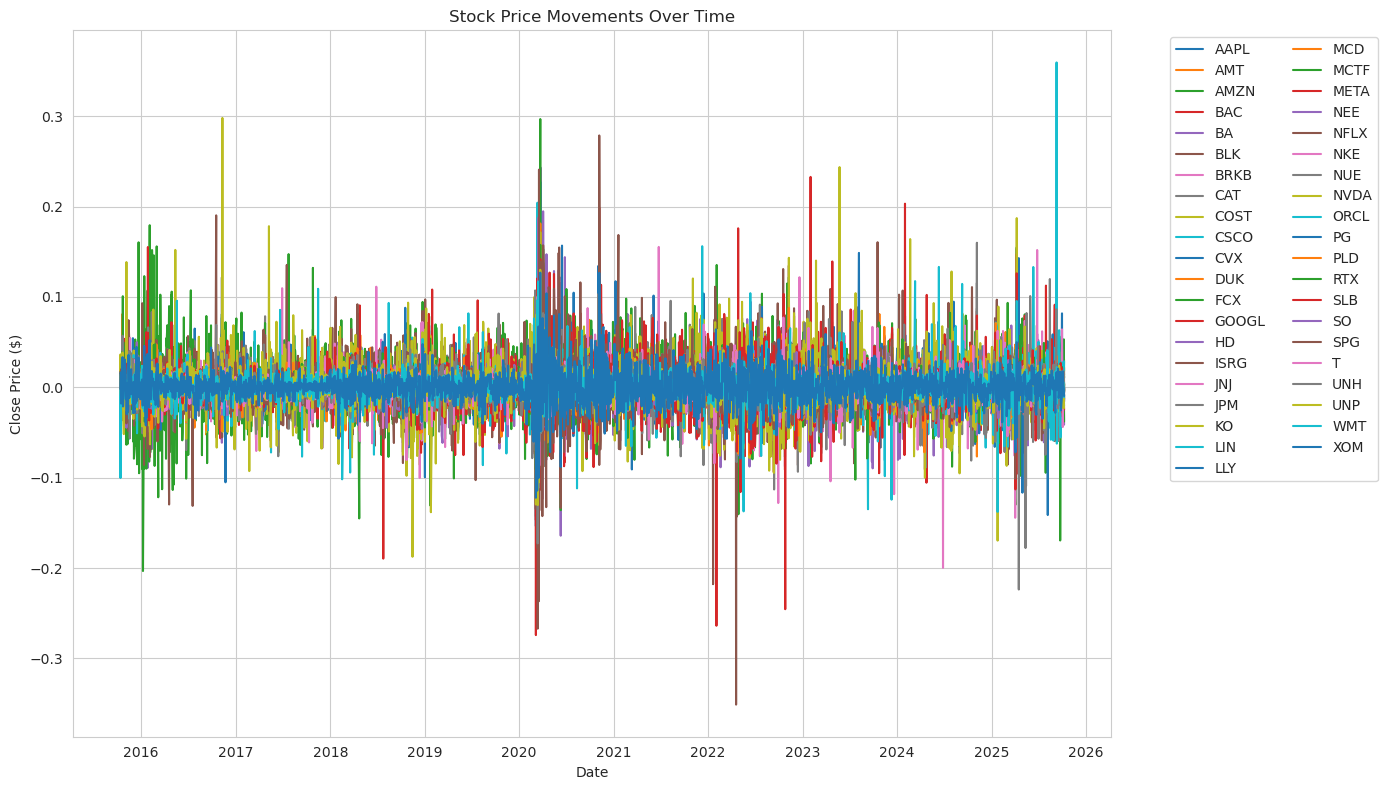

In [21]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

for ticker in listOfTickers:
    ticker_data = df[df['ticker'] == ticker]
    sns.lineplot(data=ticker_data, x='date', y='returns', label=ticker)

plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.title('Stock Price Movements Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

## Adding technical indicators

#### Compute Rolling Average Dollar Volume

In [22]:
df['dollarVol'] = df[['close', 'volume']].prod(axis=1)

In [23]:
df['dollarVol1m'] = (df.groupby('ticker')['dollarVol']
                     .rolling(window=21)
                     .mean()).values

In [24]:
df['dollarVolRank'] = (df.groupby('date')['dollarVol1m'].rank(ascending=False))

#### Compute the Relative Strength Index

In [25]:
df['rsi'] = df.groupby('ticker')['close'].transform(RSI)

#### Compute Bollinger Bands

In [26]:
def computeBB(closePrices):
    """
    Compute Bollinger Bands for a single ticker's close prices
    Returns a DataFrame with bbHigh and bbLow columns
    """
    high, _, low = BBANDS(closePrices, timeperiod=20)
    return pd.DataFrame({
        'bbHigh': high, 
        'bbLow': low
    }, index=closePrices.index)

In [27]:
bbResults = df.groupby('ticker')['close'].apply(computeBB)
bbResults = bbResults.reset_index(level=0, drop=True) # Reset index to align with original data
df = df.join(bbResults)

In [28]:
df['bbHigh'] = df['bbHigh'].sub(df['close']).div(df['bbHigh']).apply(np.log1p)
df['bbLow'] = df['close'].sub(df['bbLow']).div(df['close']).apply(np.log1p)

#### Compute Average True Range


In [29]:
def computeATR(df):
    """
    Compute normalized ATR for a single ticker
    """
    try:
        df = ATR(df['high'], df['low'], 
                 df['close'], timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    except:
        return pd.Series(np.nan, index=df.index)


In [30]:
df['atr'] = df.groupby('ticker', group_keys=False).apply(computeATR, include_groups=False)

### Compute Lagged Returns

In [31]:
df.isna().sum()

date               0
close              0
volume             0
open               0
high               0
low                0
ticker             0
returns           41
dollarVol          0
dollarVol1m      820
dollarVolRank    820
rsi              574
bbHigh           779
bbLow            779
atr              574
dtype: int64

In [32]:
df.dropna(inplace=True)

In [33]:
df.head()

,date,close,volume,open,high,low,ticker,returns,dollarVol,dollarVol1m,dollarVolRank,rsi,bbHigh,bbLow,atr
20,2015-11-09,30.1425,135317160,30.2400,30.4525,30.0125,AAPL,-0.031517,4.078797e+09,5.306464e+09,1.0,64.140002,0.035293,0.094998,-1.073763
21,2015-11-10,29.1925,236117600,29.2250,29.5175,29.0153,AAPL,-0.005652,6.892863e+09,5.473211e+09,1.0,53.006508,0.063658,0.063377,-1.052915
22,2015-11-11,29.0275,180717600,29.0925,29.3550,28.8025,AAPL,-0.003359,5.245780e+09,5.547495e+09,1.0,51.339643,0.066289,0.050860,-1.055689
23,2015-11-12,28.9300,129845400,29.0650,29.2050,28.9125,AAPL,-0.029208,3.756427e+09,5.493178e+09,1.0,50.332423,0.067786,0.042941,-1.068279
24,2015-11-13,28.0850,182221200,28.8000,28.8925,28.0675,AAPL,0.016333,5.117682e+09,5.536476e+09,1.0,42.542528,0.091787,0.012446,-1.058017


In [34]:
df.to_csv('../data/processed/stocks.csv', index=False)